# Tensil TCU Demo - ResNet-20 CIFAR

### Import the TCU driver

In [1]:
import sys
sys.path.append('/home/xilinx')

# Needed to run inference on TCU
import time
import numpy as np
import pynq
from pynq import Overlay
from tcu_pynq.driver import Driver
from tcu_pynq.architecture import pynqz1

# Needed for unpacking and displaying image data
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

### Configure the fabric and driver

In [2]:
overlay = Overlay('/home/xilinx/tensil_pynqz1.bit')
tcu = Driver(pynqz1, overlay.axi_dma_0)

### Read CIFAR-10 images

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d

cifar = unpickle('/home/xilinx/cifar-10-batches-py/test_batch')
data = cifar[b'data']
labels = cifar[b'labels']

data = data[10:20]
labels = labels[10:20]

data_norm = data.astype('float32') / 255
data_mean = np.mean(data_norm, axis=0)
data_norm -= data_mean

cifar_meta = unpickle('/home/xilinx/cifar-10-batches-py/batches.meta')
label_names = [b.decode() for b in cifar_meta[b'label_names']]

def show_img(data, n):
    plt.imshow(np.transpose(data[n].reshape((3, 32, 32)), axes=[1, 2, 0]))

def get_img(data, n):
    img = np.transpose(data_norm[n].reshape((3, 32, 32)), axes=[1, 2, 0])
    img = np.pad(img, [(0, 0), (0, 0), (0, tcu.arch.array_size - 3)], 'constant', constant_values=0)
    return img.reshape((-1, tcu.arch.array_size))

def get_label(labels, label_names, n):
    label_idx = labels[n]
    name = label_names[label_idx]
    return (label_idx, name)

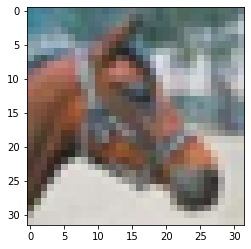

In [4]:
# CIFAR-10 input
n = 7
img = get_img(data, n)
label_idx, label = get_label(labels, label_names, n)
show_img(data, n)

## Demo: ResNet-20 inference

### Load the model

In [5]:
tcu.load_model('/home/xilinx/resnet20v2_cifar_onnx_pynqz1.tmodel')

### Run inference

In [6]:
inputs = {'x:0': img}

start = time.time()
outputs = tcu.run(inputs)
end = time.time()
print("Ran inference in {:.4}s".format(end - start))
print()

classes = outputs['Identity:0'][:10]
result_idx = np.argmax(classes)
result = label_names[result_idx]
print("Output activations:")
print(classes)
print()
print("Result: {} (idx = {})".format(result, result_idx))
print("Actual: {} (idx = {})".format(label, label_idx))

Ran inference in 0.1651s

Output activations:
[-19.49609375 -12.37890625  -8.01953125  -6.01953125  -6.609375
  -4.921875    -7.71875      2.0859375   -9.640625    -7.85546875]

Result: horse (idx = 7)
Actual: horse (idx = 7)
